In [2]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [3]:
assert torch.cuda.is_available()

In [8]:
class Generator(nn.Module):
    
    def __init__(self, d=128):
        
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            self._get_transpconv_block(100, d*8, 4, 1, 0),
            self._get_transpconv_block(d*8, d*4, 4, 2, 1),
            self._get_transpconv_block(d*4, d*2, 4, 2, 1),
            self._get_transpconv_block(d*2, d, 4, 2, 1),
            self._get_transpconv_block(d, 1, 4, 2, 1, nn.Tanh),
        )
    
    def _get_transpconv_block(self, in_channels, out_channels, kernel_size, stride, padding, activation=nn.ReLU):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=padding
        ),
            nn.BatchNorm2d(out_channels),
            activation()
        )

    # forward method
    def forward(self, latents):
        return self.model(latents)

In [9]:
G = Generator()

In [10]:
z = torch.randn((1, 100)).view(-1, 100, 1, 1)
G(z).shape

torch.Size([1, 1, 64, 64])

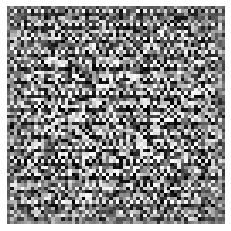

In [11]:
# Visualize the output tensor as a grayscale image
plt.imshow(G(z).view(64, 64).data.numpy(), cmap='gray')
_ = plt.axis('off')

In [ ]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):

        super(discriminator, self).__init__()

        self.model = nn.Sequential(
            self._get_conv_block(1, d, 4, 2, 1),
            self._get_conv_block(d, d*2, 4, 2, 1),
            self._get_conv_block(d*2, d*4, 4, 2, 1),
            self._get_conv_block(d*4, d*8, 4, 2, 1),
            self._get_conv_block(d*8, 1, 4, 1, 0, nn.Sigmoid),
        )
    
    def _get_conv_block(self, in_channels, out_channels, kernel_size, stride, padding, activation=nn.LeakyReLU):

        return nn.Sequential(
            nn.Conv2d(
                in_channels, 
                out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=padding
        ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    # forward method
    def forward(self, images):
        return self.model(images)

In [ ]:
D = Discriminator()

In [ ]:
img = torch.randn((1, 1, 64, 64))
D(img)